<a href="https://colab.research.google.com/github/choi00608/DataAnalysyPrograming/blob/main/202011419_%EC%B5%9C%EC%84%B1%EA%B7%9C_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*데이터분석 기말과제*
202011419 최성규

이번학기 수업을 듣는 동안, 데이터분석을 활용한 사례 중, 가장 일상에 밀접한 활용사례가 무엇일까 계속 고민 해 봤습니다.

이에, 저는 유의미하고, 분석이 가능한 데이터는 게임이 가장 적합하다고 생각했고, 그중 현재 20, 30대가 가장 많이 하는 게임인, League Of Legends(이하 lol)에 대해 분석 해 보기로 결정했습니다.


---


분석에 필요한 정보는 라이엇(lol의 모회사) 개발자포털 : https://developer.riotgames.com/ 에서 제공 받았고, 이를 바탕으로 계정 정보를 입력하면 게임 플레이 기록을 받아 올 수 있습니다.


---


또한 게임의 승패와 관련있는 요소 중, 중요하다고 생각되는 정보를 추려서 로지스틱스 회기분석을 진행해 보았습니다.

In [48]:
##데이터 준비
##라이브러리 import
import time
import pandas as pd
import numpy as np
import requests
import json
import pprint as pp

##api 키(개인 프로젝트용)
api_key = 'RGAPI-505abd17-53de-4476-b1b5-2de6e107d2d6'

##챔피언 정보
chapions = requests.get("https://ddragon.leagueoflegends.com/cdn/13.24.1/data/en_US/champion.json").json()
##챔피언 인덱스, 코드번호
chapions_key = {x : chapions["data"][x]["key"] for x in chapions["data"]}

##아이템 정보
items = requests.get("https://ddragon.leagueoflegends.com/cdn/13.24.1/data/en_US/item.json").json()
##아이템 인덱스, 코드번호
items_key = {items['data'][y]['name'] : y for y in items['data']}

##----------------------------------------------------------------------------------------------##

##게임 아이디 입력
name = input("gameid: ")
##게임 태그 입력("#" 제외)
tag = input("tag: ")

##api 요청을 위해 양식에 맞춰서 아이디 값 변조
hex_name = name.encode("utf-8").hex()
name_for_key = ""
count = 0
for i in hex_name:
    if count%2 == 0 :
        name_for_key = name_for_key + "%" + i
    else:
        name_for_key = name_for_key + i
    count = count + 1

##파라미터 입력용 아이디값
name_for_key = name_for_key.upper()

##----------------------------------------------------------------------------------------------##

##계정 정보 불러오기
account_info = requests.get(
    "https://asia.api.riotgames.com/riot/account/v1/accounts/by-riot-id/" +
    name_for_key + "/" +
    tag + "?" +
    "api_key=" +
    api_key
).json()

##계정 정보에서 puuid 값 추출
puuid = account_info["puuid"]

##RATE LIMITS 관리
print("RATE LIMITS PAUSE.....")
time.sleep(2)

##최근 80게임 매치id 가져오기(랭크게임)
recent_match = requests.get(
    "https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/" +
    puuid + "/" +
    "ids?queue=420&start=0&count=80&" +
    "api_key=" +
    api_key
).json()

##매치 기록(id)을 리스트로 저장
match_list = list(recent_match)

##매치 상세정보 json을 순서대로 저장하는 리스트
match_info_list = []
##count 초기화
count = 1

print("매치정보 불러오는 중.....")
print("RATE LIMITS PAUSE.....")
for i in match_list:
    match = requests.get(
        "https://asia.api.riotgames.com/lol/match/v5/matches/" +
        i +
        "?api_key=" +
        api_key
    ).json()

    match_info_list.append(match)

    count = count + 1

    if count%10 == 0:
        print("\r" + str(count) + " / 80" , end="")
        time.sleep(1)

print()
print("불러오기 완료")

##----------------------------------------------------------------------------------------------##


gameid: 아간조
tag: KR1
RATE LIMITS PAUSE.....
매치정보 불러오는 중.....
RATE LIMITS PAUSE.....
80 / 80
불러오기 완료


In [49]:
##읽어온 데이터로 데이터프레임을 생성합니다.


##데이터프레임에 들어갈 항목들을 변수로 선언
##선택한 챔피언
picked_champion = []

##(kill + assistant ) / death
kda = []

##처치한 미니언 / 전체 게임시간
cs_per_time = []

##획득한 총 골드 / 전체 게임시간
gold_per_time = []

##구조물에 가한 데미지 총량 / 전제 게임시간
damage_to_structure_per_time = []

##신화아이템_마법공격력 구매여부
mythic_AP = []

##신화아이템_공격력 구매여부
mythic_AD = []

##신화아이템_마법저항 구매여부
mythic_SB = []

##신화아이템_방어력 구매여부
mythic_DF = []

##기여도
##(챔피언에게 가한 피해량 + 구조물에 가한 피해량 + 설치한 와드개수 + 군중제어 횟수) / death
contribution = []

#게임시간(second)
duration = []

##승리여부
victory_or_defeat = []

for i in range(len(match_list)):
    temp = match_info_list[i]
    player_index = temp["metadata"]["participants"].index(puuid)

    picked_champion.append(temp["info"]["participants"][player_index]["championName"])
    kda.append(temp["info"]["participants"][player_index]["challenges"]["kda"])
    cs_per_time.append((temp["info"]["participants"][player_index]["neutralMinionsKilled"] + temp["info"]["participants"][player_index]["totalMinionsKilled"]) / temp["info"]["gameDuration"])
    gold_per_time.append(temp["info"]["participants"][player_index]["challenges"]["goldPerMinute"])
    damage_to_structure_per_time.append((temp["info"]["participants"][player_index]["damageDealtToTurrets"] + temp["info"]["participants"][player_index]["damageSelfMitigated"]) / temp["info"]["gameDuration"])

    for _ in ['0','1','2','3','4','5']:
        tem = str(temp["info"]["participants"][player_index]["item" + _])
        if tem == "0":
            print(end="")
        elif "Mythic" in items["data"][tem]["description"]:
            ##if Damage -> SpellDamage -> Armor -> SpellBlock -> Health
            if "Damage" in items["data"][tem]["tags"]:
                mythic_AP.append(0)
                mythic_AD.append(1)
                mythic_SB.append(0)
                mythic_DF.append(0)
                break
            elif "SpellDamage" in items["data"][tem]["tags"]:
                mythic_AP.append(1)
                mythic_AD.append(0)
                mythic_SB.append(0)
                mythic_DF.append(0)
                break
            elif "Armor" in items["data"][tem]["tags"]:
                mythic_AP.append(0)
                mythic_AD.append(0)
                mythic_SB.append(0)
                mythic_DF.append(1)
                break
            elif "SpellBlock" in items["data"][tem]["tags"]:
                mythic_AP.append(0)
                mythic_AD.append(0)
                mythic_SB.append(1)
                mythic_DF.append(0)
                break
            elif "Health" in items["data"][tem]["tags"]:
                mythic_AP.append(0)
                mythic_AD.append(0)
                mythic_SB.append(0)
                mythic_DF.append(1)
                break
        if _ == '5':
            mythic_AP.append(0)
            mythic_AD.append(0)
            mythic_SB.append(0)
            mythic_DF.append(0)

    contribution.append((temp["info"]["participants"][player_index]["damageDealtToTurrets"] +
                         temp["info"]["participants"][player_index]["damageSelfMitigated"] +
                         temp["info"]["participants"][player_index]["totalDamageDealtToChampions"] +
                         temp["info"]["participants"][player_index]["wardsPlaced"] +
                         temp["info"]["participants"][player_index]["timeCCingOthers"]) / temp["info"]["gameDuration"])

    duration.append(temp["info"]["gameDuration"])

    victory_or_defeat.append(int(temp["info"]["participants"][player_index]["win"]))


dict = {
        "victory_or_defeat" : victory_or_defeat,
        "chapions" : picked_champion,
        "KDA" : kda,
        "cs_per_time" : cs_per_time,
        "gold_per_time" : gold_per_time,
        "damage_to_structure_per_time" : damage_to_structure_per_time,
        "mythic_AP" : mythic_AP,
        "mythic_AD" : mythic_AD,
        "mythic_SB" : mythic_SB,
        "mythic_DF" : mythic_DF,
        "contribution" : contribution,
        "duration" : duration
        }

df = pd.DataFrame(dict)
#df = pd.get_dummies(df, columns = ["chapions"], dtype = int)
df

,victory_or_defeat,chapions,KDA,cs_per_time,gold_per_time,damage_to_structure_per_time,mythic_AP,mythic_AD,mythic_SB,mythic_DF,contribution,duration
0,0,Janna,2.222222,0.051309,268.575235,7.929984,1,0,0,0,14.590059,1871
1,1,Aatrox,1.222222,0.110102,458.251872,19.047673,0,1,0,0,31.911464,1762
2,0,Talon,1.571429,0.128533,439.978336,13.729600,0,1,0,0,25.969067,1875
3,1,MasterYi,1.333333,0.105046,372.617019,8.605561,0,0,0,0,12.860968,971
4,1,Evelynn,7.000000,0.110358,420.556608,6.623427,1,0,0,0,11.022265,1033
...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,Singed,1.857143,0.105234,340.053247,17.062704,0,0,0,0,25.467285,1834
76,0,Sett,0.857143,0.133374,438.143821,20.691008,0,1,0,0,31.378395,1657
77,0,Aphelios,0.454545,0.106111,324.915792,6.039624,0,1,0,0,13.601746,1489
78,0,Varus,4.000000,0.100152,439.372035,6.830551,0,0,0,0,18.117350,1977




---


게임 승패에 연관되어있다고 생각한 요소들은 다음과 같습니다.

사용한 챔피언,  킬/데스/어시스트,  초당 미니언 처치 수,  초당 획득한 골드,  초당 구조물에 가한 피해량,  신화 아이템 종류별 구매여부,  기여도,  게임시간

*기여도 = (구조물에 가한피해량 + 상대 챔피언에게 가한 피해량 + 설치한 와드 개수 + 군중제어스킬 사용횟수) / 데스


---

위의 정보를 바탕으로 회기분석을 진행합니다

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy : 0.8125
precision : 0.875
recall : 0.7777777777777778
f1 : 0.823529411764706


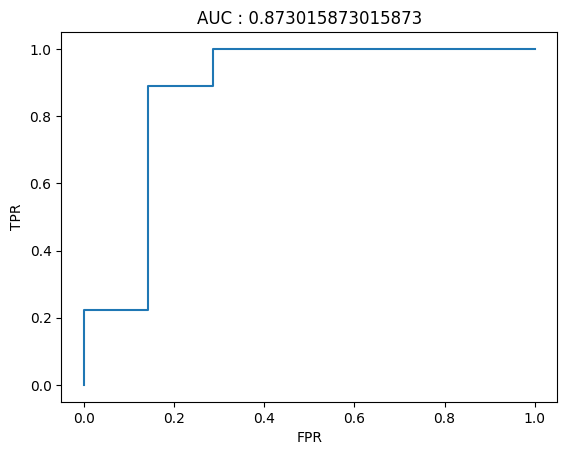

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

df_data = pd.DataFrame(df)

df_data = pd.get_dummies(df_data, columns = ["chapions"], dtype = int)
X = df_data.iloc[:, 1:]
y = df_data.iloc[:, 0]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1986)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

# 성능을 평가하기 위해, Accuracy, Precision, Recall, F1 Score를 계산.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('accuracy : ' + str(accuracy))
print('precision : ' + str(precision))
print('recall : ' + str(recall))
print('f1 : ' + str(f1))

plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'AUC : {auc}')

plt.show()